In [1]:
import datetime
import os
import socket

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import helpers

def log(*message):
    time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
    print(time, *message)

In [2]:
# TODO: pass these as arguments
snap = 99
sim = 'tng100-3'
log(f'Extracting data for {sim} for snapshot {snap}')

if socket.gethostname() == 'lenovo-p52':
    base_dir = '/home/rmcg/data/'
else:
    base_dir = '/disk01/rmcg/'
sim_dir = f'{base_dir}downloaded/tng/{sim}/'
lhalotree_dir = sim_dir + 'merger_tree/lhalotree/'
with h5py.File(lhalotree_dir+'trees_sf1_099.0.hdf5', 'r') as file:
    redshifts = np.array(file['/Header/Redshifts'])
scale_factors = 1 / (1 + redshifts)

2022-07-01 16:14 Extracting data for tng100-3 for snapshot 99


## Finding valid subhalo pairs
<u> Problems </u>
- How to define a valid galaxy? Should I implement a stellar mass cut?
- Assert that diff_dm_mass is positive?

In [3]:
# sub refers to subhalo at snap
# prog refers to progenitor subhalo at snap-1

data = {}
data['sub_id'] = np.array([], dtype='int32')
data['prog_id'] = np.array([], dtype='int32')
data['sub_stellar_mass'] = np.array([], dtype='float32')
data['prog_stellar_mass'] = np.array([], dtype='float32')
data['diff_dm_mass'] = np.array([], dtype='float32')
#TODO: run for all files
for file_name in os.listdir(lhalotree_dir)[:1]:
    log(f'Processing {file_name}')
    with h5py.File(lhalotree_dir+file_name, 'r') as file:
        for tree_name in [key for key in file.keys() if 'Tree' in key]:
            # TODO: Units
            arr_sub_id = np.array(file[tree_name+'/SubhaloNumber'])
            arr_gas_mass = np.array(file[tree_name+'/SubhaloMassType'][:, 0])
            arr_dm_mass = np.array(file[tree_name+'/SubhaloMassType'][:, 1])
            arr_stellar_mass = np.array(file[tree_name+'/SubhaloMassType'][:, 4])
            arr_snap_num = np.array(file[tree_name+'/SnapNum'])
            
            arr_central_index = np.array(file[tree_name+'/FirstHaloInFOFGroup'])
            arr_is_central = np.zeros(arr_sub_id.shape[0], dtype=bool)
            for i_sub, i_central in enumerate(arr_central_index):
                arr_is_central[i_sub] = (i_sub == i_central)
                
            arr_prog_index = np.array(file[tree_name+'/FirstProgenitor'])
            arr_prog_id = -1 * np.ones(arr_sub_id.shape[0], dtype='int32')
            arr_prog_dm_mass = np.zeros(arr_sub_id.shape[0], dtype='float32')
            arr_prog_stellar_mass = np.zeros(arr_sub_id.shape[0], dtype='float32')
            for i_sub, i_prog in enumerate(arr_prog_index.copy()):
                if (
                        i_prog != -1 and                      # Check progenitor exists
                        arr_snap_num[i_prog] == snap - 1 and  # Check snapshot isn't skipped
                        arr_is_central[i_prog] and            # Require central subhalo
                        arr_stellar_mass[i_prog] != 0 and     # Require nonzero stellar mass
                        arr_gas_mass[i_prog] != 0             # Require nonzero gas mass
                    ):
                    arr_prog_id[i_sub] = arr_sub_id[i_prog]
                    arr_prog_dm_mass[i_sub] = arr_dm_mass[i_prog]
                    arr_prog_stellar_mass[i_sub] = arr_stellar_mass[i_prog]

            mask = (arr_snap_num == snap)
            mask &= arr_is_central
            mask &= (arr_prog_id != -1)
            mask &= (arr_stellar_mass != 0)
            mask &= (arr_gas_mass != 0)
            
            data['sub_id'] = np.concatenate([data['sub_id'], arr_sub_id[mask]])
            data['prog_id'] = np.concatenate([data['prog_id'], arr_prog_id[mask]])
            data['sub_stellar_mass'] = np.concatenate([data['sub_stellar_mass'], arr_stellar_mass[mask]])
            data['prog_stellar_mass'] = np.concatenate([data['prog_stellar_mass'], arr_prog_stellar_mass[mask]])
            diff_dm_mass = arr_dm_mass[mask] - arr_prog_dm_mass[mask]
            diff_dm_mass[diff_dm_mass < 0] = 0
            data['diff_dm_mass'] = np.concatenate([data['diff_dm_mass'], diff_dm_mass])
            
n_valid = data['sub_id'].shape[0]
log(f'{n_valid} galaxies found')

2022-07-01 16:14 Processing trees_sf1_099.0.hdf5
2022-07-01 16:15 1562 galaxies found


<img src="papers/basic_picture.png"/>


## Gas rates
- Use set operations based on particle IDs
- Calculating gas temp can be taken from [here](https://www.tng-project.org/data/forum/topic/338/cold-and-hot-gas/)

<u> Problems </u>
- What happens to particle IDs when gas cells split?
- Gas cells are different masses in prog and sub snapshots (average over both?)
- What to return for galaxies which have no cold gas?


## Star rates
- Use GFM_StellarFormationTime to calculate number of stars formed

<u> Problems </u>
- Stellar particles brought in through mergers aren't accounted for, may mean I underestimate stellar mass
- Stellar masses evolve over time
- Wind particles
- Stellar mass from particles is sometimes more than from subfind (only less by factor of 10^7)

In [4]:
def calculate_efficiencies(snap, sub_id, prog_id, diff_dm_mass, 
                           sub_stellar_mass, prog_stellar_mass):
    
    # Calculations using gas particles
    gas_fields = ['Masses', 'ParticleIDs', 'StarFormationRate']
    prog_g = helpers.loadSubhalo(sim_dir, snap-1, prog_id, 0, fields=gas_fields)
    prog_is_cold_gas = prog_g['StarFormationRate'] > 0
    prog_is_hot_gas = np.logical_not(prog_is_cold_gas)
    prog_cold_gas_ids = prog_g['ParticleIDs'][prog_is_cold_gas]
    prog_hot_gas_ids = prog_g['ParticleIDs'][prog_is_hot_gas]
    
    sub_g = helpers.loadSubhalo(sim_dir, snap, sub_id, 0, fields=gas_fields)
    sub_is_cold_gas = sub_g['StarFormationRate'] > 0
    sub_is_hot_gas = np.logical_not(sub_is_cold_gas)
    sub_cold_gas_ids = sub_g['ParticleIDs'][sub_is_cold_gas]
    sub_hot_gas_ids = sub_g['ParticleIDs'][sub_is_hot_gas]
    
    rate_hot_cold = 0
    hot_to_cold_ids = set(np.intersect1d(prog_hot_gas_ids, sub_cold_gas_ids))
    for (part_id, mass) in zip(sub_cold_gas_ids, sub_g['Masses'][sub_is_cold_gas]):
        if part_id in hot_to_cold_ids:
            rate_hot_cold += mass
        
    rate_cold_hot = 0
    cold_to_hot_ids = set(np.intersect1d(prog_cold_gas_ids, sub_hot_gas_ids))
    for (part_id, mass) in zip(prog_cold_gas_ids, prog_g['Masses'][prog_is_cold_gas]):
        if part_id in cold_to_hot_ids:
            rate_cold_hot += mass
    
    rate_accrete_hot = 0
    accrete_hot_ids = set(np.setdiff1d(sub_hot_gas_ids, prog_g['ParticleIDs']))
    for (part_id, mass) in zip(sub_hot_gas_ids, sub_g['Masses'][sub_is_hot_gas]):
        if part_id in accrete_hot_ids:
            rate_accrete_hot += mass
    
    cold_gas_mass = np.sum(sub_g['Masses'][sub_is_cold_gas])
    hot_gas_mass = np.sum(sub_g['Masses'][sub_is_hot_gas])
     
    # Calculations using star particles
    stellar_fields = ['GFM_StellarFormationTime', 'Masses']
    sub_s = helpers.loadSubhalo(sim_dir, snap, sub_id, 4, fields=stellar_fields)
    sub_ratio = sub_stellar_mass / np.sum(sub_s['Masses'])
    assert abs(sub_ratio - 1) < 0.001, f'Sub stellar ratio: {sub_ratio:.3g}'
#     assert np.isclose(sub_stellar_mass, np.sum(sub_s['Masses']), rtol=1e-3), 'Sub stellar mass'
    recently_formed = sub_s['GFM_StellarFormationTime'] > scale_factors[snap-1]
    rate_cold_stars = np.sum(sub_s['Masses'][recently_formed])

    prog_s = helpers.loadSubhalo(sim_dir, snap-1, prog_id, 4, fields=['Masses'])
    prog_ratio = prog_stellar_mass / np.sum(prog_s)
    assert abs(prog_ratio - 1) < 0.001, f'Prog stellar ratio: {prog_ratio:.3g}'
#     assert np.isclose(prog_stellar_mass, np.sum(prog_s), rtol=1e-3), 'Prog stellar mass'
    
    # Calculating efficiencies
    f_a = rate_accrete_hot / diff_dm_mass if diff_dm_mass else -1
    f_c = rate_hot_cold / hot_gas_mass if hot_gas_mass else -1
    f_s = rate_cold_stars / cold_gas_mass if cold_gas_mass else -1
    f_d = rate_cold_hot / rate_cold_stars if rate_cold_stars else -1
    
    return f_a, f_c, f_s, f_d

In [5]:
log(f'Calculating efficiencies')
data['f_a'] = np.zeros(n_valid, dtype='float32')
data['f_c'] = np.zeros(n_valid, dtype='float32')
data['f_s'] = np.zeros(n_valid, dtype='float32')
data['f_d'] = np.zeros(n_valid, dtype='float32')
for i in range(n_valid):
    if not (i+1) % (n_valid // 20):
        log(f'{round(100*(i+1)/n_valid)}% complete')
    
    sub_id = data['sub_id'][i]
    prog_id = data['prog_id'][i]
    diff_dm_mass = data['diff_dm_mass'][i]
    sub_stellar_mass = data['sub_stellar_mass'][i]
    prog_stellar_mass = data['prog_stellar_mass'][i]
    try:
        f_a, f_c, f_s, f_d = calculate_efficiencies(
            snap, sub_id, prog_id, diff_dm_mass, sub_stellar_mass, prog_stellar_mass
        )
        data['f_a'][i] = f_a
        data['f_c'][i] = f_c
        data['f_s'][i] = f_s
        data['f_d'][i] = f_d
    except AssertionError as error_message:
        log(f'{error_message} AssertionError for i={i}')

2022-07-01 16:15 Calculating efficiencies
2022-07-01 16:15 5% complete
2022-07-01 16:15 10% complete
2022-07-01 16:15 15% complete
2022-07-01 16:15 20% complete
2022-07-01 16:15 25% complete
2022-07-01 16:15 Sub stellar ratio: 0.997 AssertionError for i=461
2022-07-01 16:15 30% complete
2022-07-01 16:15 Prog stellar ratio: 0.982 AssertionError for i=524
2022-07-01 16:15 Prog stellar ratio: 0.998 AssertionError for i=541
2022-07-01 16:15 35% complete
2022-07-01 16:15 Prog stellar ratio: 0.965 AssertionError for i=580
2022-07-01 16:15 40% complete
2022-07-01 16:15 45% complete
2022-07-01 16:15 50% complete
2022-07-01 16:15 55% complete
2022-07-01 16:15 Prog stellar ratio: 0.998 AssertionError for i=889
2022-07-01 16:15 Prog stellar ratio: 0.97 AssertionError for i=932
2022-07-01 16:15 60% complete
2022-07-01 16:15 65% complete
2022-07-01 16:15 70% complete
2022-07-01 16:15 75% complete
2022-07-01 16:15 80% complete
2022-07-01 16:15 Sub stellar ratio: 0.998 AssertionError for i=1251
2022-

In [6]:
log(f'Saving data')
save_data_dir = f'{base_dir}generated/sim_sam/{sim}/'
if not os.path.exists(save_data_dir):
    os.makedirs(save_data_dir)
pd.DataFrame(data).to_parquet(f'{save_data_dir}snap_{snap}.parquet')

2022-07-01 16:15 Saving data


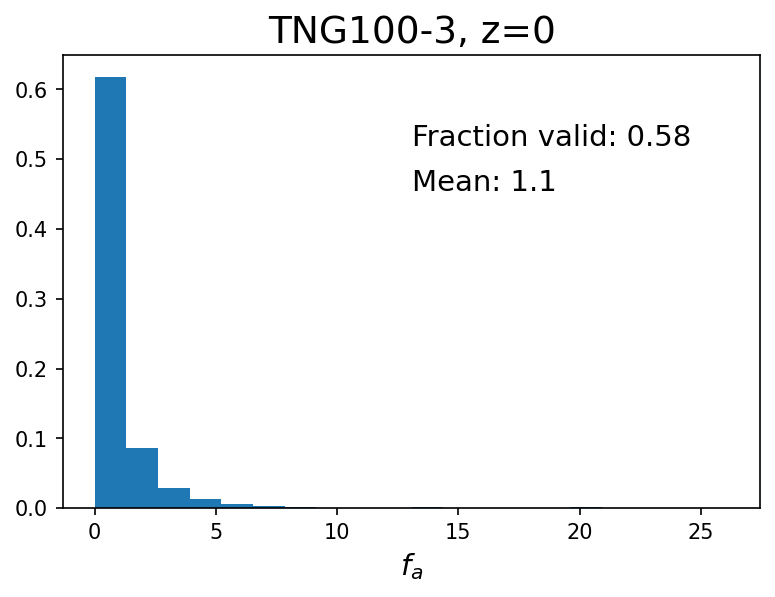

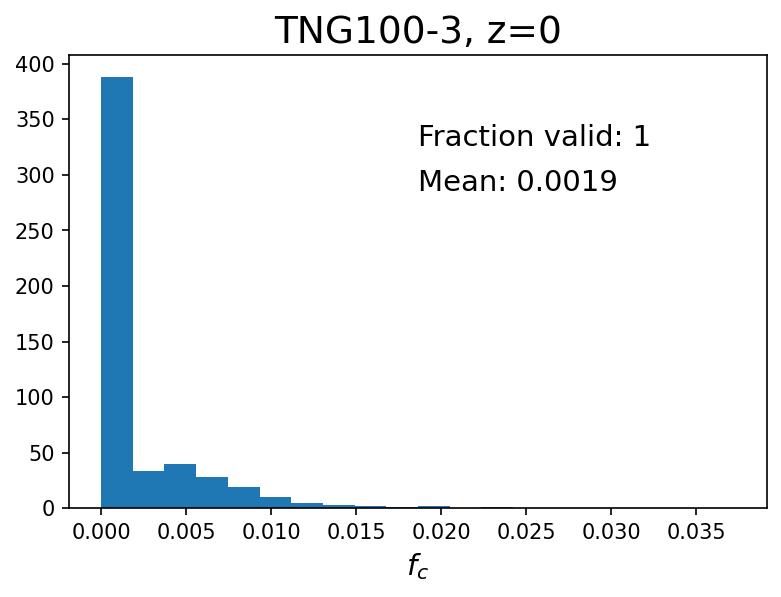

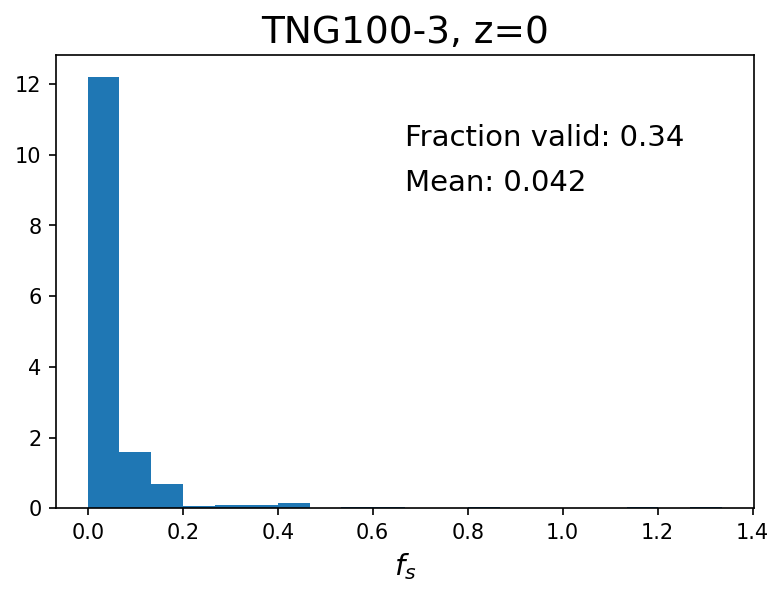

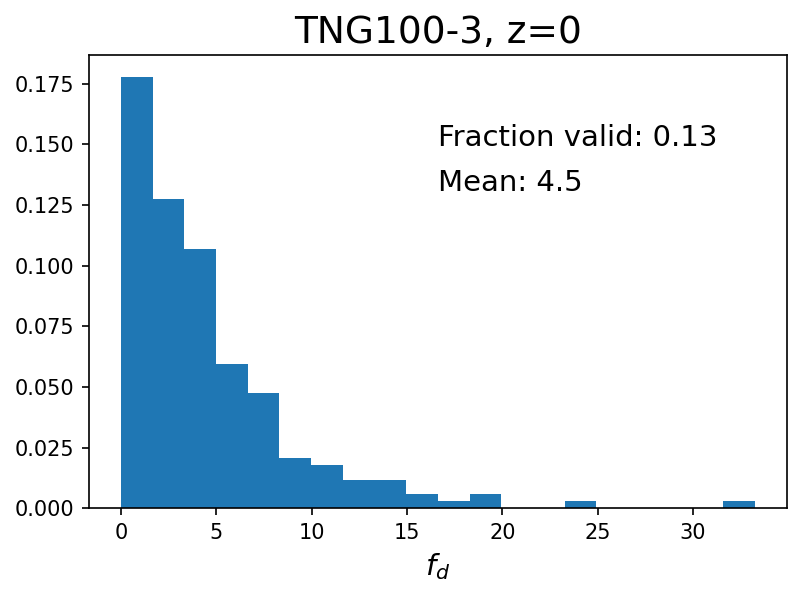

In [25]:
# Should this be in a separate file?
for efficiency in ['f_a', 'f_c', 'f_s', 'f_d']:
    fig, ax = plt.subplots(1, dpi=150)
    mask = data[efficiency] != -1
    ax.hist(data[efficiency][mask], density=True, bins=20)
    ax.text(0.5, 0.8, f'Fraction valid: {np.sum(mask)/mask.shape[0]:.2g}',
            transform=ax.transAxes, fontsize=14)
    ax.text(0.5, 0.7, f'Mean: {np.mean(data[efficiency][mask]):.2g}',
            transform=ax.transAxes, fontsize=14)
    ax.set_title(f'{sim.upper()}, z={round(redshifts[snap])}', fontsize=18)
    ax.set_xlabel(f'${efficiency}$', fontsize=14)
    
    plt.savefig(f'/home/rmcg/{sim}_{efficiency}_hist_snap{snap}.png')
    plt.show()
    plt.close()

In [8]:
# TODO: Multiprocessing
# TODO: Merger tree for single galaxies, print efficiencies (separate file)
# TODO: Save data alongside plots, save plots as pdf
easdgasdkglja

NameError: name 'easdgasdkglja' is not defined

In [ ]:
# How much does gas mass change? Assumes prog_id=0 is progenitor of sub_id=0
sub_g = helpers.loadSubhalo(sim_dir, 99, 0, 0, fields=['Masses', 'ParticleIDs'])
prog_g = helpers.loadSubhalo(sim_dir, 98, 0, 0, fields=['Masses', 'ParticleIDs'])

sub_ids = sub_g['ParticleIDs']
print(f'Len sub_ids: {sub_ids.shape[0]}')
prog_ids = prog_g['ParticleIDs']
print(f'Len prog_ids: {prog_ids.shape[0]}')
intersect = np.intersect1d(sub_ids, prog_ids)
print(f'Len intersect: {intersect.shape[0]}')

for part_id in intersect[:5]:
    sub_mass = sub_g['Masses'][sub_g['ParticleIDs'] == part_id][0]
    prog_mass = prog_g['Masses'][prog_g['ParticleIDs'] == part_id][0]
    print(f'Prog mass: {prog_mass:.3g}, sub mass: {sub_mass:.3g}, increase: {sub_mass > prog_mass}')